# tensorboard terminal cmd

In [ ]:
# tensorboard --logdir="./logs/"      

# Ensure kernel not breakdown

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'


# All imports

In [4]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
import gymnasium as gym
from stable_baselines3 import PPO,DQN
from stable_baselines3.common.callbacks import BaseCallback
import tensorboard
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.logger import configure
import os

# UAV class

In [6]:
# UAV class representing a UAV node
class UAV:
    def __init__(self, uav_id, position):
        self.uav_id = uav_id
        self.position = position  # (x, y)

# Cluster Head class

In [8]:
# ClusterHead class representing a cluster head node
class ClusterHead:
    def __init__(self, head_id, position):
        self.head_id = head_id
        self.position = position  # (x, y)

# UAV Swarm Environment

In [10]:
# Custom environment using gymnasium
class UAVSwarmEnv(gym.Env):
    def __init__(self, grid_size, num_cluster_heads, transmission_range, num_uavs):
        super(UAVSwarmEnv, self).__init__()
        self.grid_size = grid_size
        self.num_cluster_heads = num_cluster_heads
        self.transmission_range = transmission_range
        self.efficient_threshold = self.transmission_range * 0.8
        self.num_uavs = num_uavs
        self.cluster_heads = []
        self.uavs = []
        self.current_step = 0
        
        self.setup_environment()

        # Define action and observation space
        self.action_space = gym.spaces.Discrete(num_uavs*5)  # Each action corresponds to a UAV's action
        self.observation_space = gym.spaces.Box(low=0, high=grid_size, shape=(2, num_cluster_heads), dtype=np.float32)

    def setup_environment(self):
        # Place cluster heads while ensuring distance constraints
        positions = []
        while len(self.cluster_heads) < self.num_cluster_heads:
            position = (random.uniform(0, self.grid_size), random.uniform(0, self.grid_size))
            if self.is_valid_position(position, positions):
                self.cluster_heads.append(ClusterHead(len(self.cluster_heads), position))
                positions.append(position)

        # Place UAVs randomly in the grid
        for uav_id in range(self.num_uavs):
            uav_position = (random.uniform(0, self.grid_size), random.uniform(0, self.grid_size))\
            # uav_position = (0,0)
            self.uavs.append(UAV(uav_id=uav_id, position=uav_position))

    def is_valid_position(self, new_position, existing_positions):
        for pos in existing_positions:
            distance = np.linalg.norm(np.array(new_position) - np.array(pos))
            if distance <= 2 * self.transmission_range:
                return False  # Too close to another cluster head
        return True

    def step(self, action):
        # Determine which UAV to move and in which direction
        num_uavs = len(self.uavs)
        uav_index = action // 5  # Adjusted for 5 actions: 4 directions + stay
        move_direction = action % 5  # Adjusted for the new action set
    
        # Validate UAV index
        if uav_index >= num_uavs:
            raise ValueError("Invalid action, UAV index out of bounds")
    
        # Select the UAV based on the action
        uav = self.uavs[uav_index]
        previous_position = uav.position  # Save the previous position
    
        # Define movement: 0 = stay, 1 = right, 2 = left, 3 = up, 4 = down
        if move_direction == 0:
            move = (0,0)
            pass
        elif move_direction == 1:
            move = (1, 0)  # Move right
        elif move_direction == 2:
            move = (-1, 0)  # Move left
        elif move_direction == 3:
            move = (0, 1)  # Move up
        elif move_direction == 4:
            move = (0, -1)  # Move down
    
        # Apply movement within the grid boundaries
        uav.position = (max(0, min(self.grid_size, uav.position[0] + move[0])),
                        max(0, min(self.grid_size, uav.position[1] + move[1])))
    
        # Calculate the reward
        reward = self.calculate_reward(uav, previous_position)
    
        # Update the environment state
        self.current_step += 1
    
        # Define termination conditions
        terminated = False  # Custom termination condition
        truncated = self.current_step >= 100  # Example: episode ends after 100 steps
    
        # Return observation, reward, termination status, truncation status, and additional info
        return self.get_observation(), reward, terminated, truncated, {}

    def calculate_reward(self, uav, previous_position):
        # Initialize reward
        reward = 0
    
        # Check direct connections established and reward based on their quality
        for i, ch1 in enumerate(self.cluster_heads):
            for ch2 in self.cluster_heads[i + 1:]:
                if self.can_communicate(ch1, ch2):
                    # Reward based on the distance between cluster heads
                    distance_between_chs = self.distance(ch1.position, ch2.position)
                    reward += max(0, 10 - distance_between_chs)  # Closer connections yield higher rewards
    
        # Reward based on the distance the UAV moved, encouraging efficient movement
        distance_moved = np.linalg.norm(np.array(uav.position) - np.array(previous_position))
        if distance_moved > 0:
            # Reward exploration with diminishing returns to prevent excessive movement without purpose
            reward += min(5, distance_moved)  # Cap the reward for movement
    
        # Check if the UAV has moved closer to any cluster head
        closest_ch = self.get_closest_cluster_head(uav)
        if closest_ch and self.distance(uav.position, closest_ch.position) < self.transmission_range:
            reward += 5  # Bonus for getting close to a cluster head
    
        # Penalty for too many steps without connections
        if self.current_step % 10 == 0:  # Every 10 steps
            if not any(self.can_communicate(ch1, ch2) for ch1 in self.cluster_heads for ch2 in self.cluster_heads):
                reward -= 0.5 * (self.current_step // 10)  # Increase penalty based on inactivity
    
        # Energy efficiency consideration
        energy_used = self.calculate_energy_usage(previous_position)  # Assume this function calculates energy usage
        if energy_used > self.efficient_threshold:
            reward -= (energy_used - self.efficient_threshold) * 0.1  # Penalize excess energy use
    
        # Reward for achieving specific goals, if applicable
        # if self.goal_achieved():
        #     reward += 20  # Significant reward for achieving the goal
    
        return reward
    
    def distance(self, pos1, pos2):
        """Calculate the Euclidean distance between two positions."""
        return np.linalg.norm(np.array(pos1) - np.array(pos2))
    
    def can_communicate(self, ch1, ch2):
        """Determine if two cluster heads can communicate based on their distance."""
        return self.distance(ch1.position, ch2.position) <= self.transmission_range
    
    def get_closest_cluster_head(self, uav):
        """Find the closest cluster head to the given UAV."""
        closest_ch = None
        min_distance = float('inf')
        
        for ch in self.cluster_heads:
            dist = self.distance(uav.position, ch.position)
            if dist < min_distance:
                min_distance = dist
                closest_ch = ch
                
        return closest_ch
    
    def calculate_energy_usage(self,previous_position):
        """Calculate the energy used by the UAVs during movements and communications."""
        # Implement your energy calculation logic here
        # For example, a simple model could be:
        energy_used = sum(np.linalg.norm(np.array(uav.position) - np.array(previous_position)) 
                            for uav in self.uavs)
        return energy_used

    # def goal_achieved(self):
    #     """Check if the UAVs have completed their mission or achieved a specific goal."""
    #     # Define the logic to determine if a goal is achieved
    #     # For example, it might involve checking the number of connections or the distance to a target
    #     return self.some_condition_for_goal_completion  # Replace with actual condition



    def can_communicate(self, start_ch, target_ch):
        visited = set()  # To keep track of visited nodes
        queue = [start_ch]  # Start BFS with the initial cluster 
        while queue:
            current = queue.pop(0)  # Dequeue the first cluster head
            if current.head_id == target_ch.head_id:
                return True  # Found the target cluster head

            # Check for communication through UAVs
            for uav in self.uavs:
                dist_start = np.linalg.norm(np.array(current.position) - np.array(uav.position))
                if dist_start <= 2*self.transmission_range:  # Can communicate with UAV
                    # Check other cluster heads for communication through the same UAV
                    for other_ch in self.cluster_heads:
                        if other_ch.head_id != current.head_id:  # Avoid self-loop
                            dist_other = np.linalg.norm(np.array(other_ch.position) - np.array(uav.position))
                            if dist_other <= 2*self.transmission_range and other_ch not in visited:
                                visited.add(other_ch)  # Mark as visited
                                queue.append(other_ch)  # Enqueue for further exploration
                                
        return False  # No path found to the target cluster head


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Ensure the seed is passed to the parent class
        if seed is not None:
            self.seed(seed)
            
        self.cluster_heads = []
        self.uavs = []
        self.current_step = 0
        self.setup_environment()  # Reinitialize environment
        initial_observation = self.get_observation()
        info = {}  # You can include any additional info here if needed in the future
        return (initial_observation,info)

    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]

    def get_observation(self):
        # Return the positions of cluster heads as the observation
        observation = np.zeros((2, self.num_cluster_heads), dtype=np.float32)  # Ensure dtype is float32
        for i, ch in enumerate(self.cluster_heads):
            observation[0, i] = float(ch.position[0])  # Cast to float
            observation[1, i] = float(ch.position[1])  # Cast to float
        return observation

    def render(self, mode='human'):
        plt.figure(figsize=(6, 6))
        
        # Render Cluster Heads
        for i, ch in enumerate(self.cluster_heads):
            plt.scatter(ch.position[0], ch.position[1], color='red', s=200, marker='o', label='Cluster Head' if i == 0 else "")
            # Draw transmission range area
            circle = plt.Circle(ch.position, self.transmission_range, color='red', alpha=0.1)
            plt.gca().add_patch(circle)
        
        # Render UAVs
        for i, uav in enumerate(self.uavs):
            plt.scatter(uav.position[0], uav.position[1], color='blue', s=100, marker='x', label='UAV' if i == 0 else "")
            # Draw transmission range area
            circle = plt.Circle(uav.position, self.transmission_range, color='blue', alpha=0.1)
            plt.gca().add_patch(circle)
        
        # Set plot limits and labels
        plt.xlim(0, self.grid_size)
        plt.ylim(0, self.grid_size)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("UAV Swarm Environment")
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.grid(True)
        
        # Display legend (only if cluster heads and UAVs are non-empty)
        if len(self.cluster_heads) > 0 or len(self.uavs) > 0:
            plt.legend(loc='upper right')
        
        # Handle mode: 'human' or 'rgb_array'
        if mode == 'human':
            plt.show()  # Display plot for human mode
        elif mode == 'rgb_array':
            # Save plot to a numpy array and return the RGB image
            plt.gca().figure.canvas.draw()
            # Use buffer_rgba to get the RGBA image
            image = np.frombuffer(plt.gca().figure.canvas.buffer_rgba(), dtype=np.uint8)
            # Convert to the proper shape
            image = image.reshape(plt.gca().figure.canvas.get_width_height()[::-1] + (4,))
            plt.close()  # Close the plot to avoid overlapping
            return image
        
        
        
            # Custom legend to avoid duplicates
            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            plt.legend(by_label.values(), by_label.keys())
        
            plt.show()
    


# create and render Environment

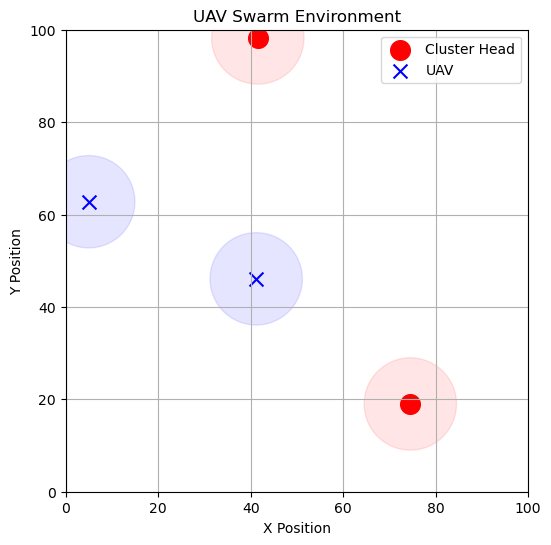

In [58]:
env = UAVSwarmEnv(grid_size=100, num_cluster_heads=2, transmission_range=10, num_uavs=2)
env.render()

# check environment with openai gym

In [22]:
check_env(env)

C:\Users\aashi\anaconda3\Lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


In [24]:
# Logging and saving directories
log_path = "./logs/"
save_path = "./models/"

In [26]:
tensorboard_callback = EvalCallback(env, log_path=log_path, eval_freq=1000, best_model_save_path=log_path)

In [28]:
# Initialize the PPO model
model = PPO(
    "MlpPolicy", 
    env, 
    learning_rate=3e-4, 
    n_steps=2048, 
    n_epochs=5,
    batch_size=64, 
    ent_coef=0.01, 
    gamma=0.99, 
    clip_range=0.2, 
    verbose=1, 
    tensorboard_log=log_path
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [29]:
# Train the agent
model.learn(total_timesteps=100000)

Logging to ./logs/PPO_3
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -1.83e+03 |
| time/              |           |
|    fps             | 88        |
|    iterations      | 1         |
|    time_elapsed    | 23        |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.83e+03    |
| time/                   |              |
|    fps                  | 68           |
|    iterations           | 2            |
|    time_elapsed         | 59           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0014212853 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.22        |
|    explained_variance 

KeyboardInterrupt: 

In [ ]:
model.save(save_path + "ppo_uav_swarm")

In [44]:
model = DQN(
    "MlpPolicy",                 # DQN uses MlpPolicy for neural networks
    env,                         # The environment
    learning_rate=3e-4,          # Learning rate for the model
    buffer_size=1000000,         # Replay buffer size
    learning_starts=50000,       # Number of steps before learning starts
    batch_size=64,               # Mini-batch size
    tau=1.0,                     # Soft update coefficient for target network
    gamma=0.99,                  # Discount factor
    train_freq=4,                # Frequency of training
    gradient_steps=1,            # Gradient steps after each training step
    target_update_interval=10000,# Number of steps before updating target network
    exploration_fraction=0.1,    # Fraction of training period where exploration rate is annealed
    exploration_final_eps=0.02,  # Final value of epsilon for exploration
    exploration_initial_eps=1.0, # Initial value of epsilon for exploration
    verbose=1,                   # Verbosity level
    tensorboard_log=log_path     # TensorBoard log directory
)

TypeError: DQN.__init__() got an unexpected keyword argument 'n_epochs'

In [ ]:
model.learn(total_timesteps=100000)

In [ ]:
model.save(save_path + "dqn_uav_swarm")

In [34]:
# Save the UAV swarm environment simulation as a video (GIF or other formats).

import imageio
import time

def saveVideo(env, model, filename="uav_simulation.mp4", num_episodes=100, fps=10, deterministic=True, frame_delay=0.1):
    """
    Parameters:
    - env: the environment instance
    - model: the trained RL model
    - filename: name of the file to save the video (should end with .gif, .mp4, etc.)
    - num_episodes: number of episodes to record
    - fps: frames per second for the output video
    - deterministic: if True, use deterministic actions from the model
    - frame_delay: time (in seconds) to wait between each frame (adjusts the simulation speed)
    """
    frames = []  # Store frames to create video
    obs, _ = env.reset()
    
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        print(f"Recording Episode {episode + 1}/{num_episodes}")
        
        while not done:
            # Predict action using the trained model
            action, _ = model.predict(obs, deterministic=deterministic)
            obs, reward, done, truncated, info = env.step(action)

            # Render and capture the frame
            frame = env.render(mode='rgb_array')  # Get RGB array from render
            plt.imshow(frame)
            plt.axis('off')
            plt.show()
            
            frames.append(frame)
            
            if done or truncated:
                break
    
    # Save the frames as a video file using imageio
    print(f"Saving video to {filename}")
    imageio.mimsave(filename, frames, fps=fps)  # Save as GIF or MP4
    
    print(f"Video saved as {filename}")
    


Recording Episode 1/1


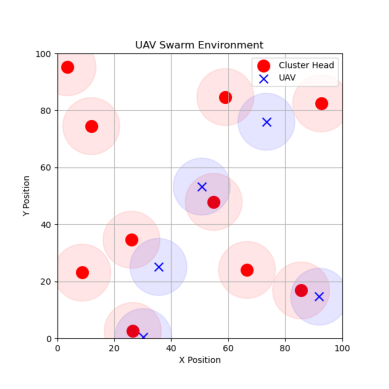

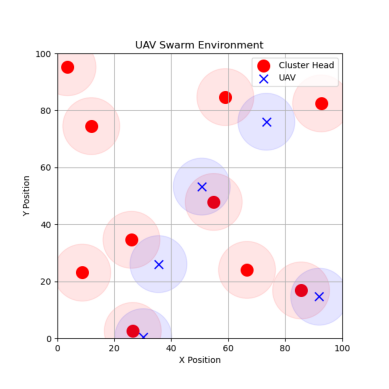

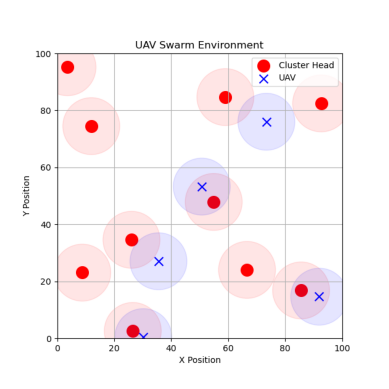

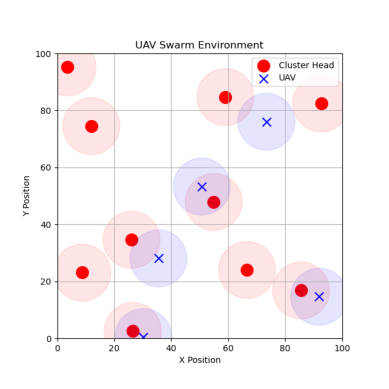

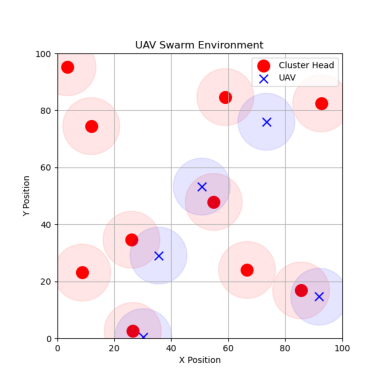

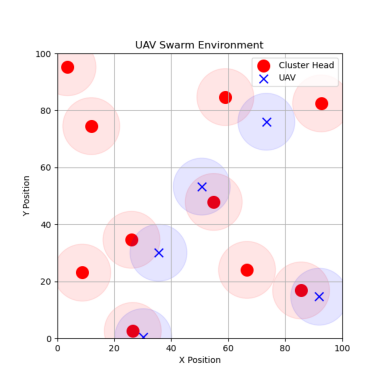

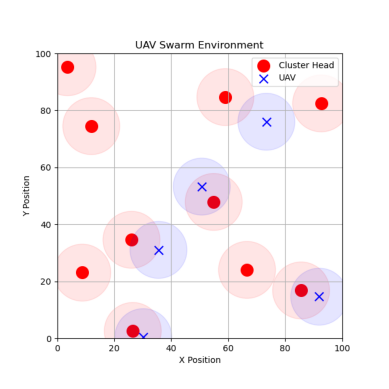

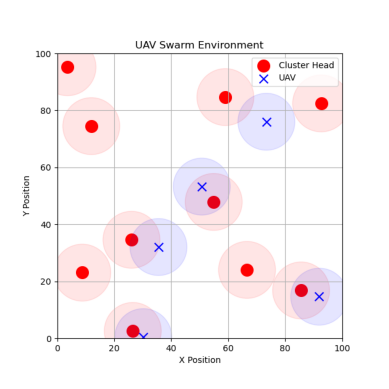

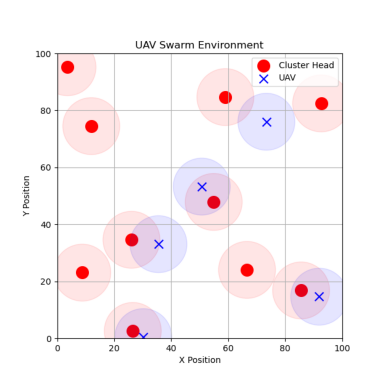

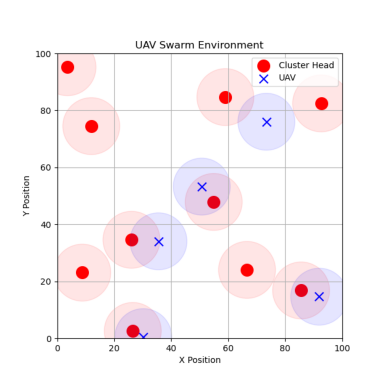

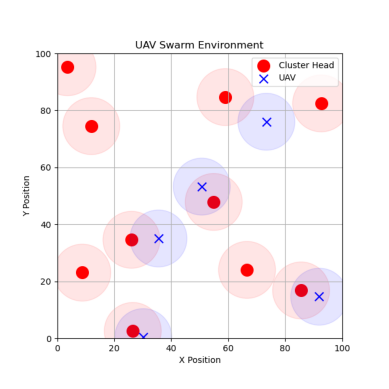

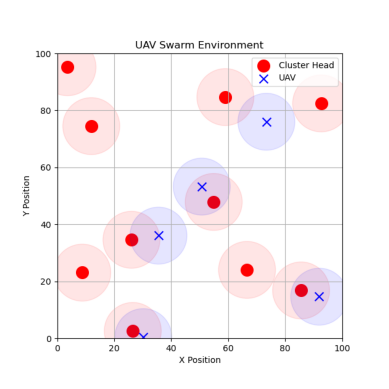

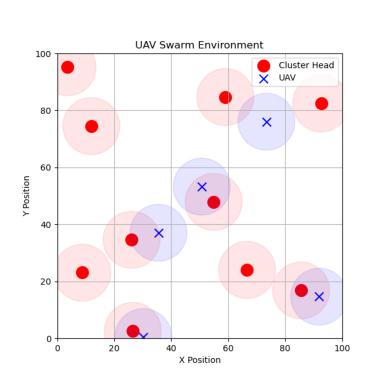

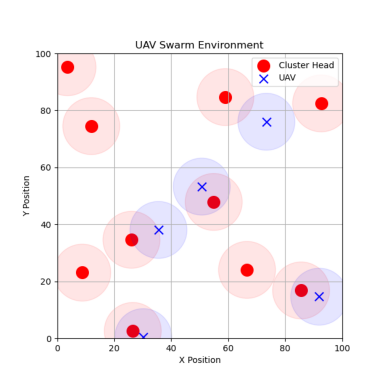

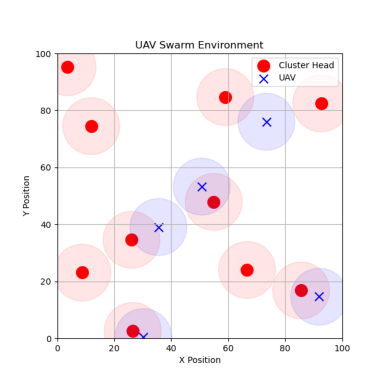

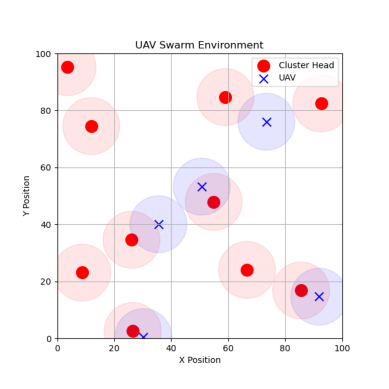

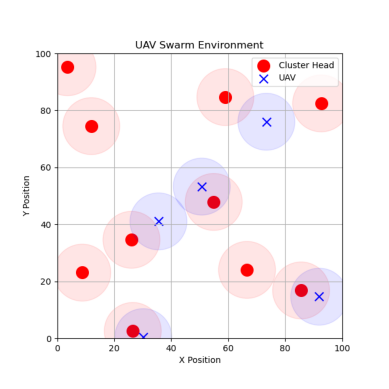

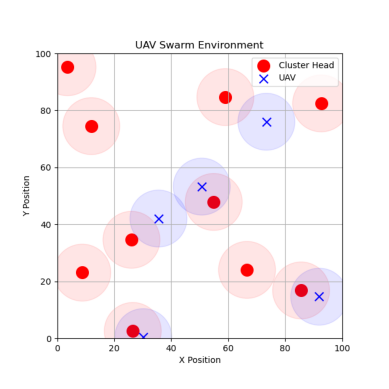

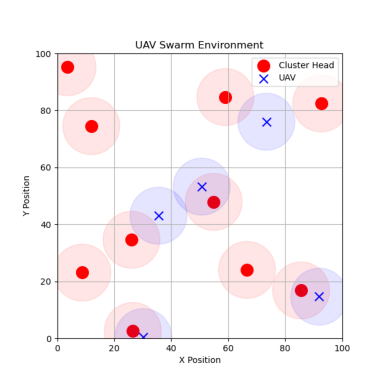

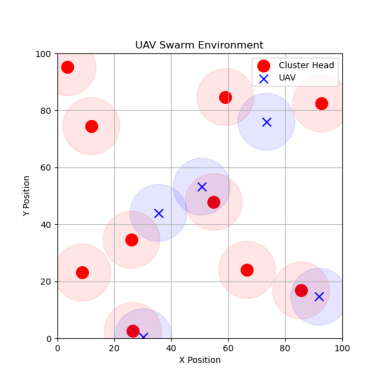

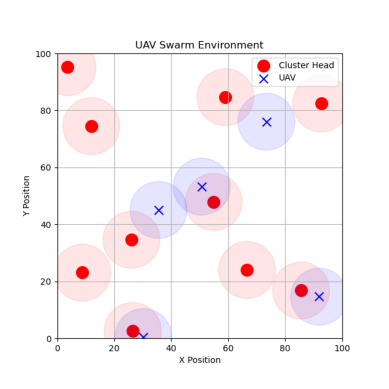

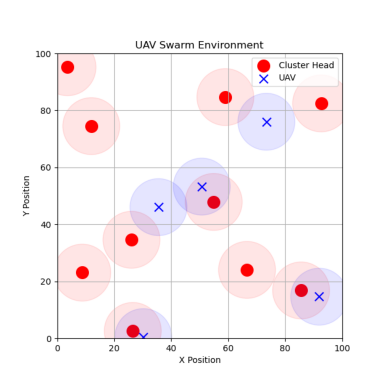

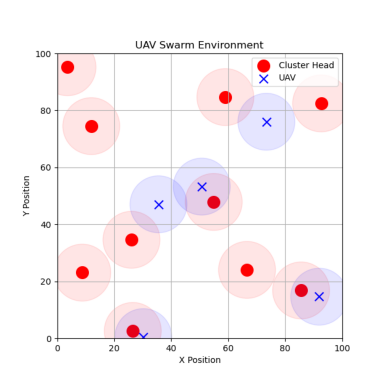

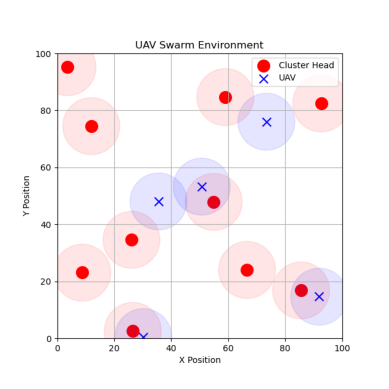

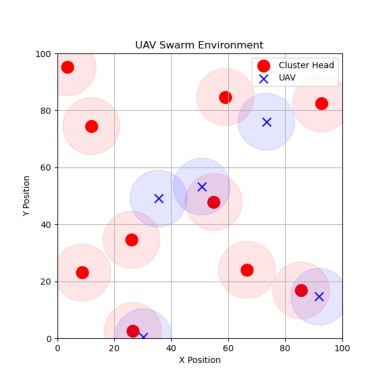

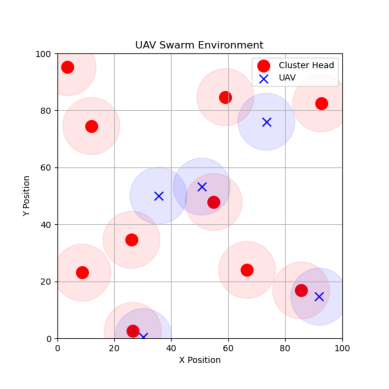

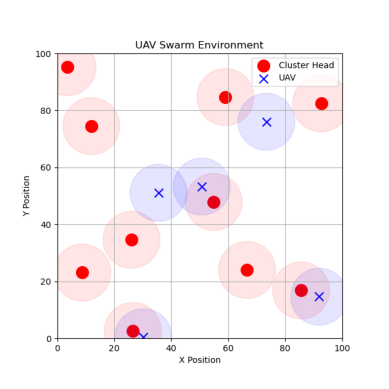

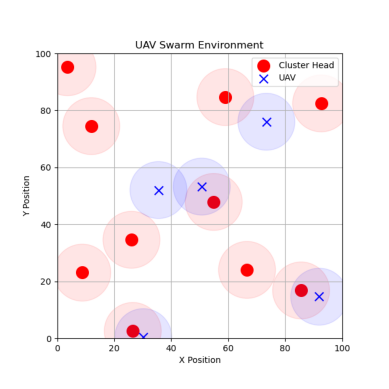

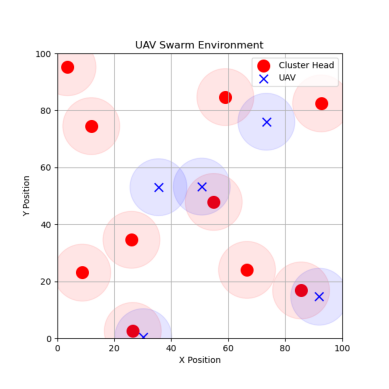

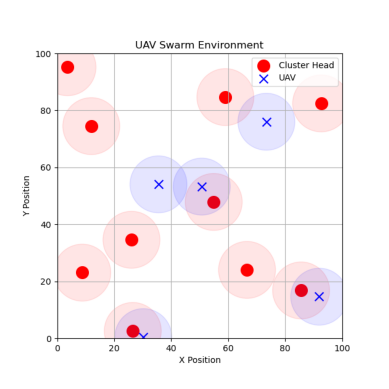

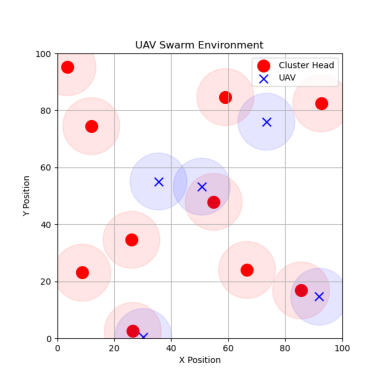

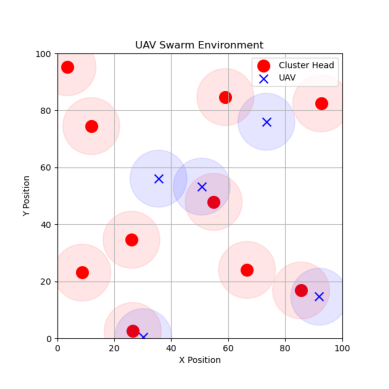

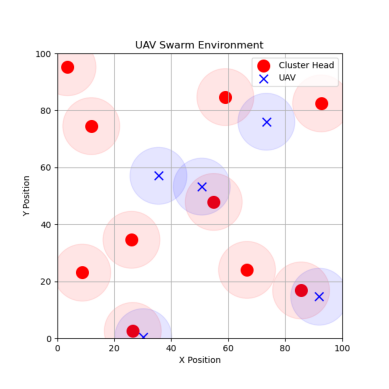

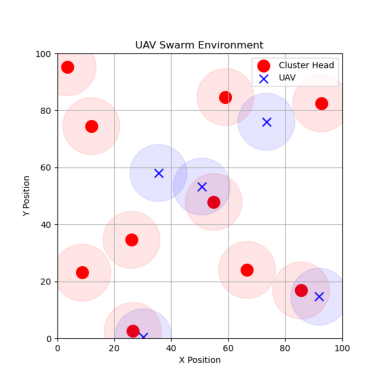

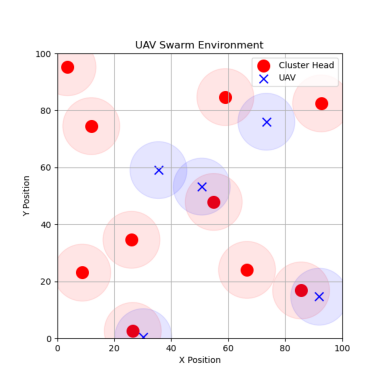

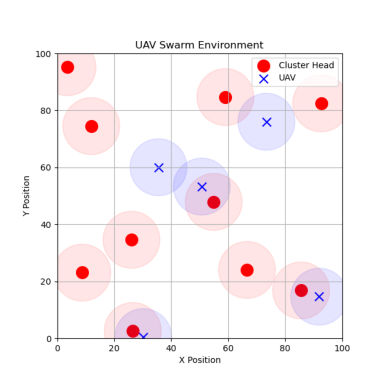

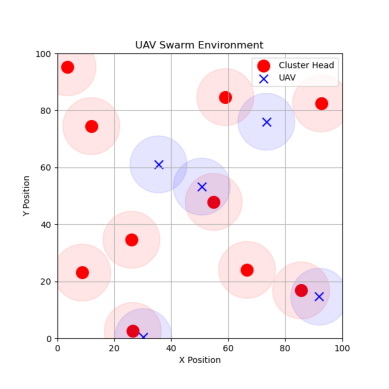

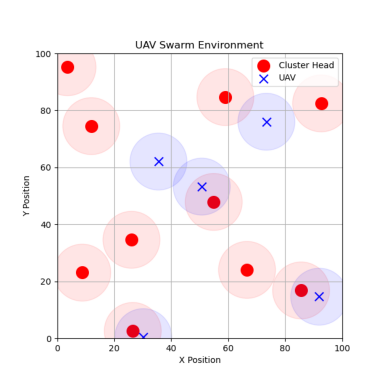

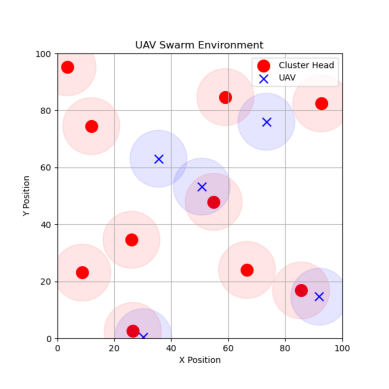

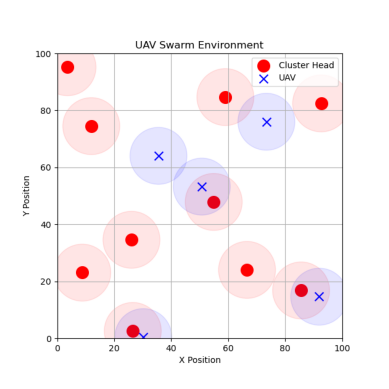

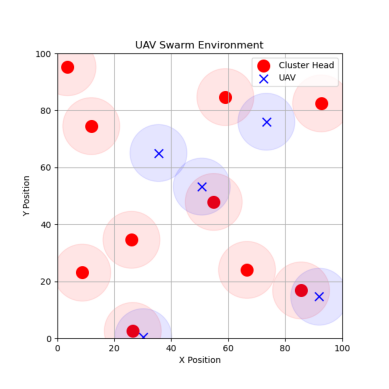

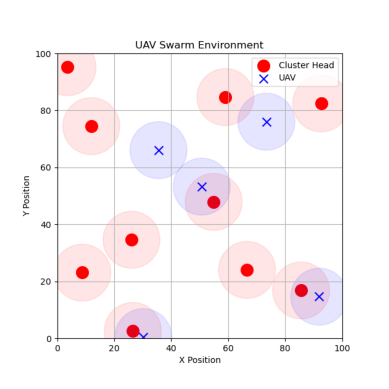

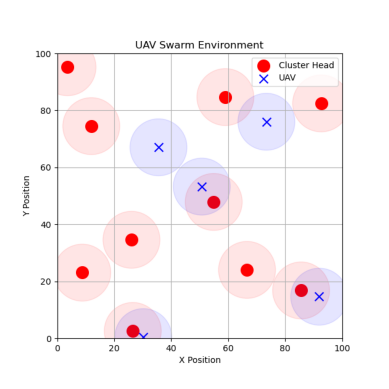

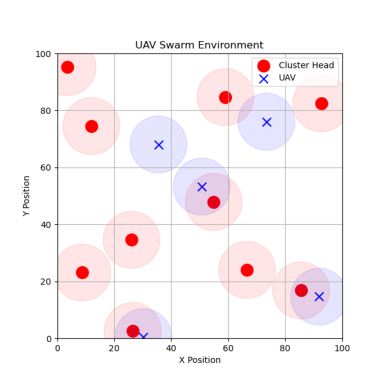

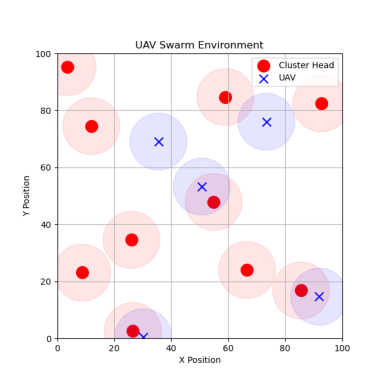

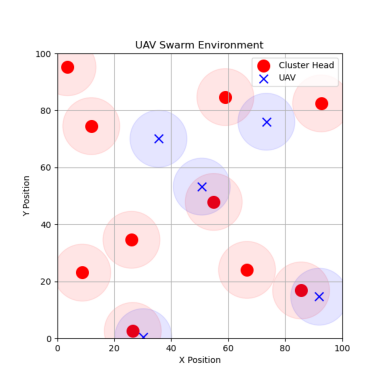

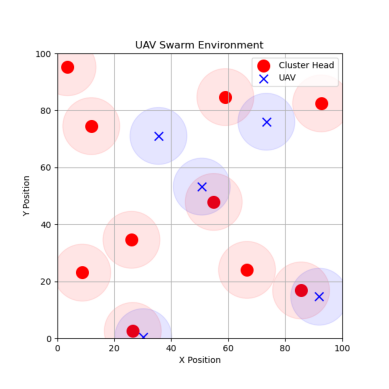

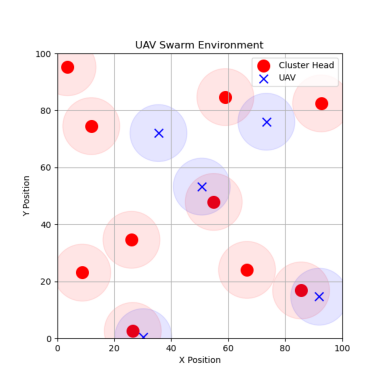

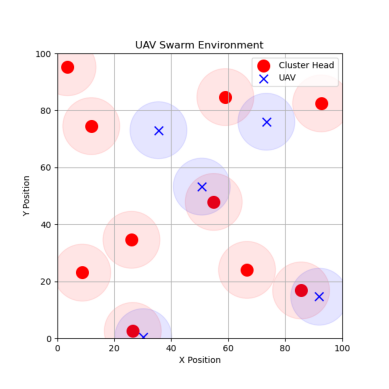

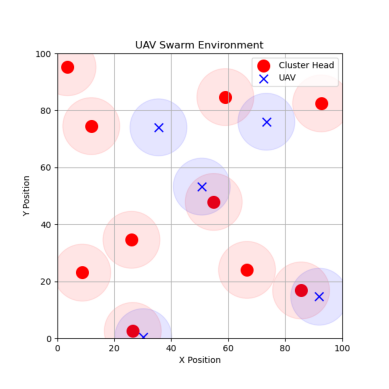

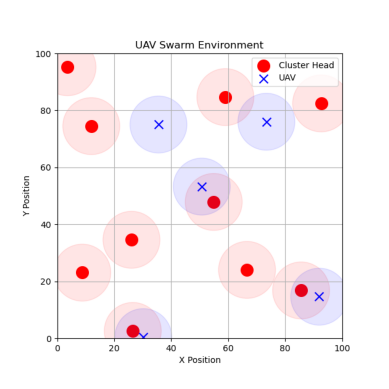

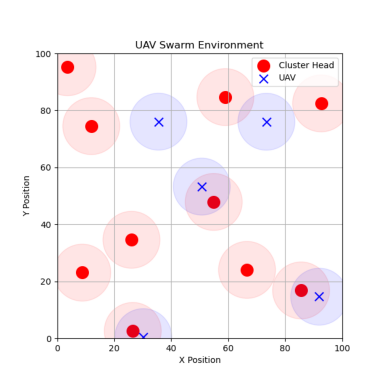

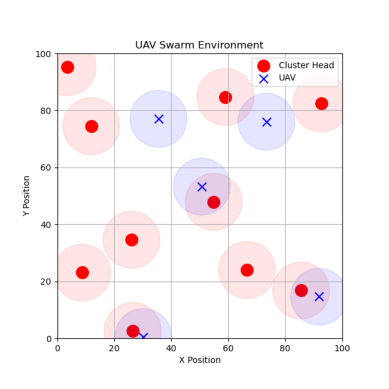

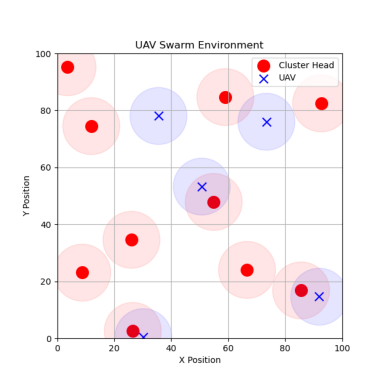

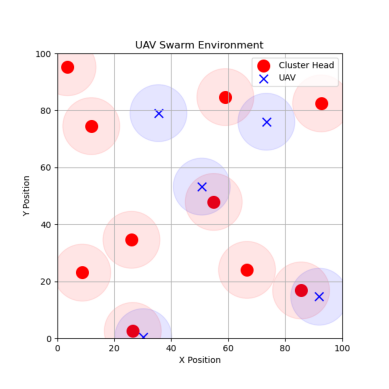

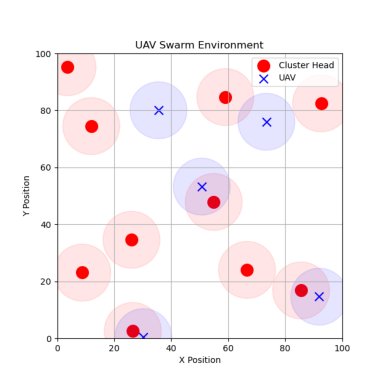

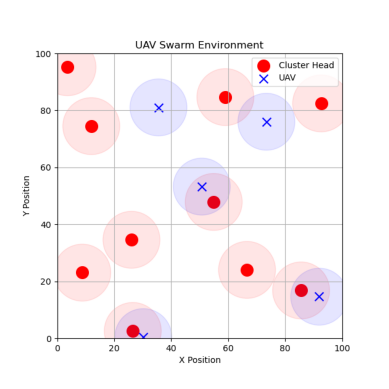

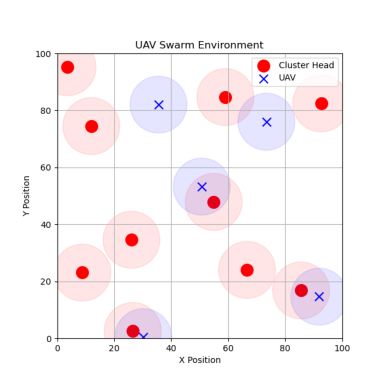

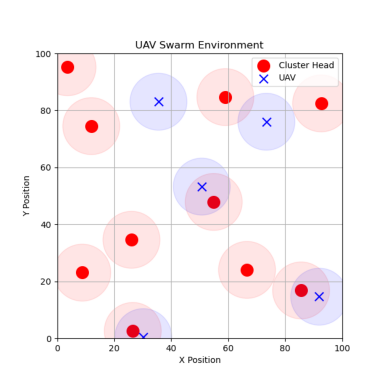

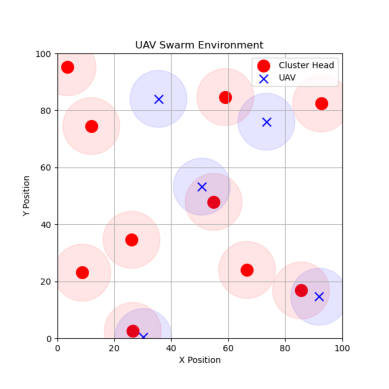

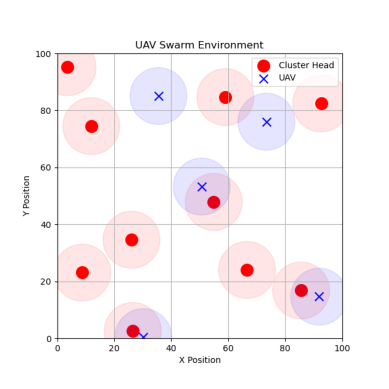

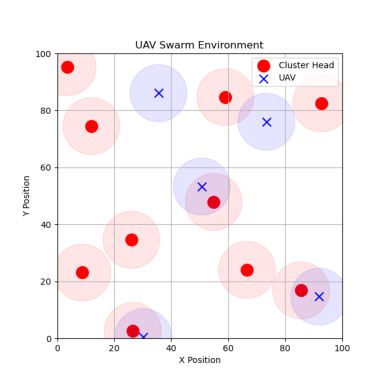

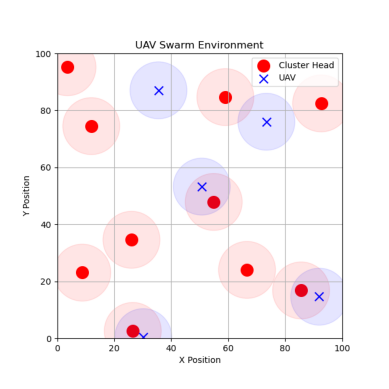

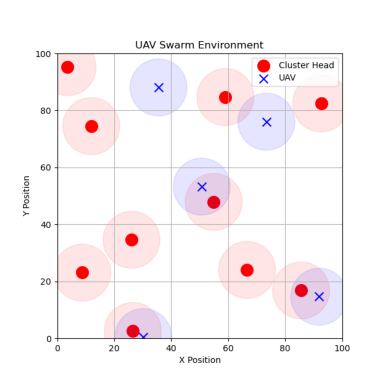

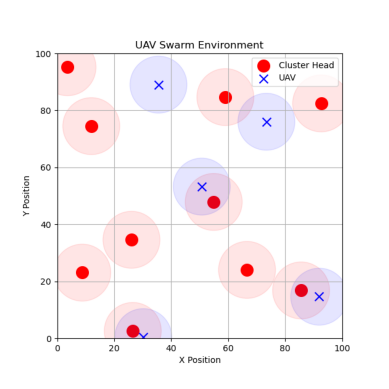

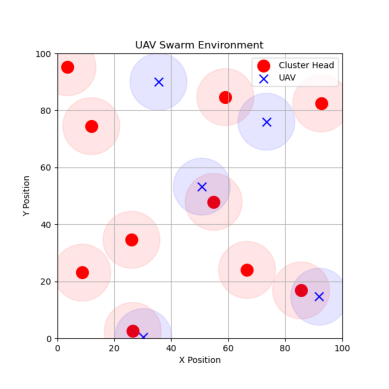

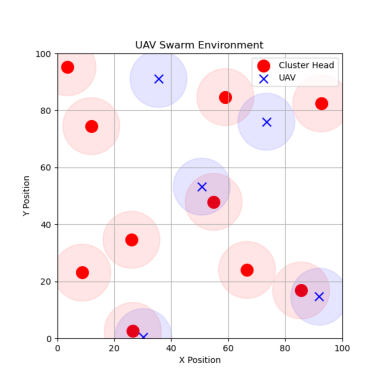

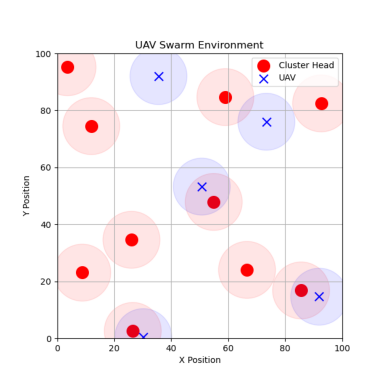

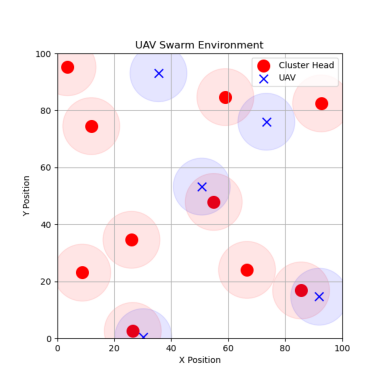

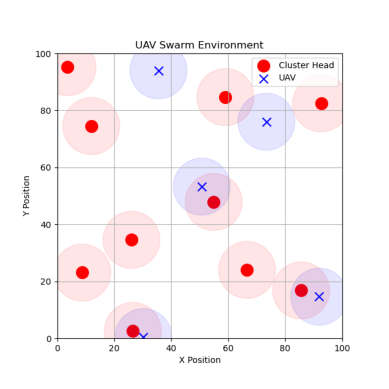

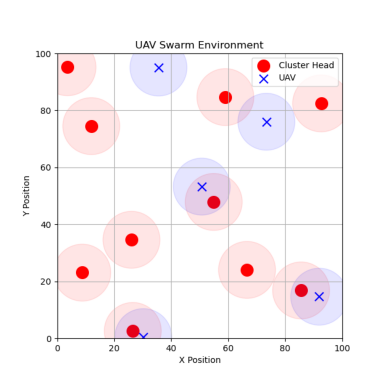

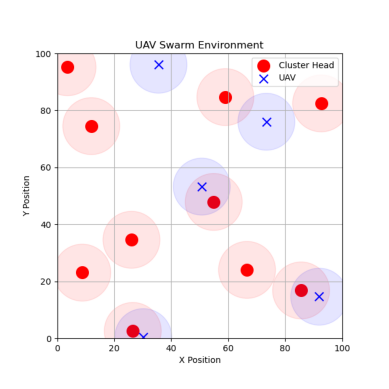

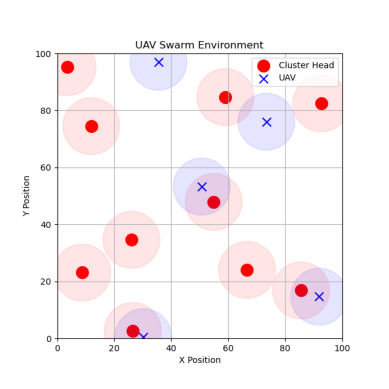

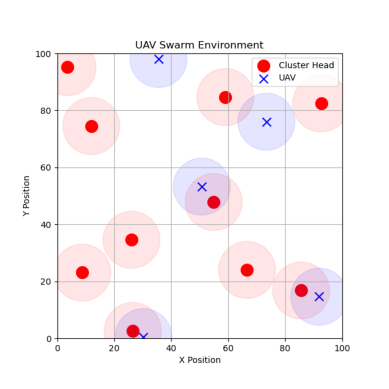

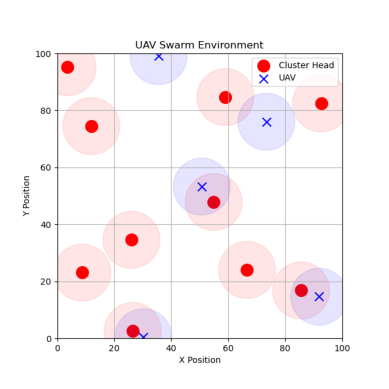

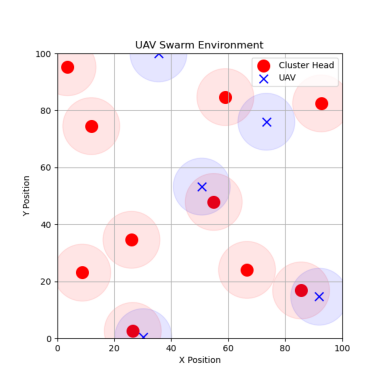

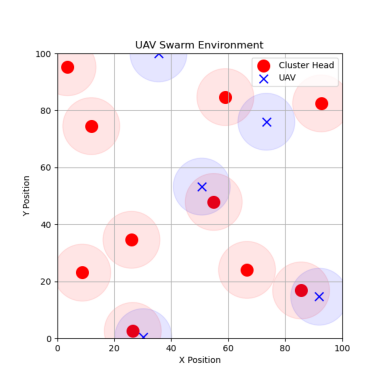

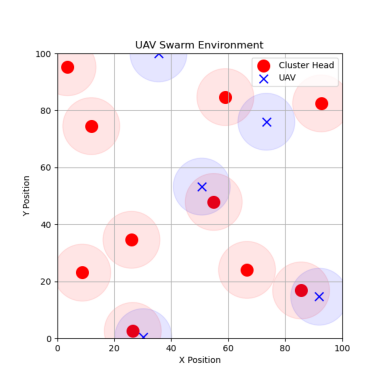

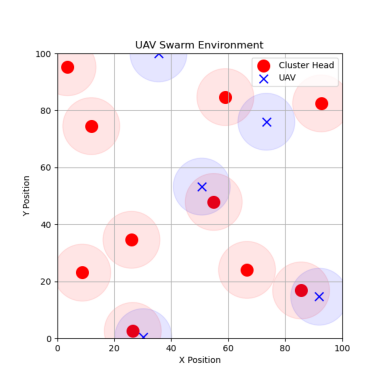

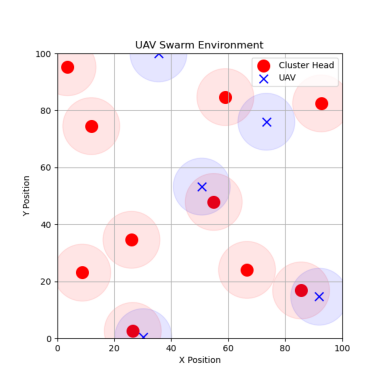

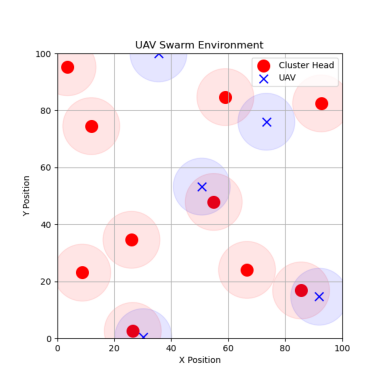

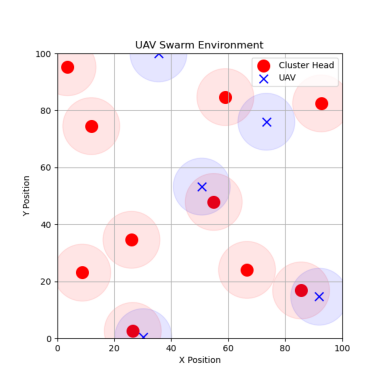

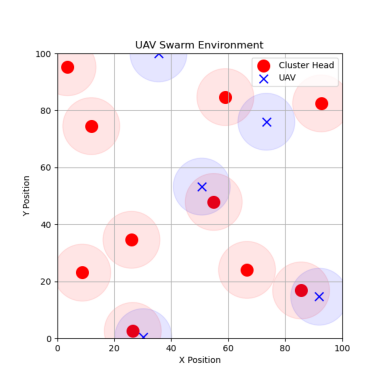

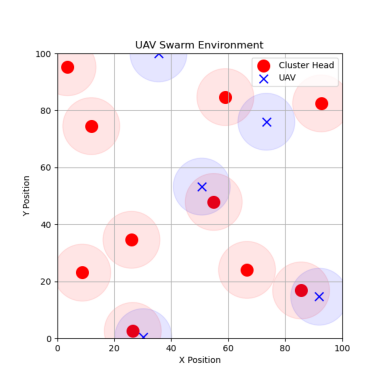

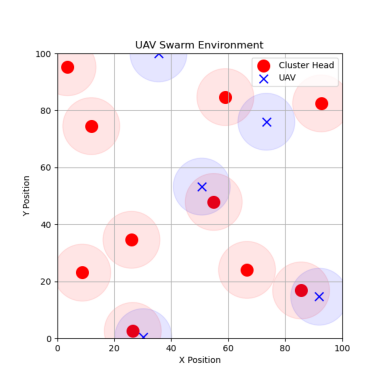

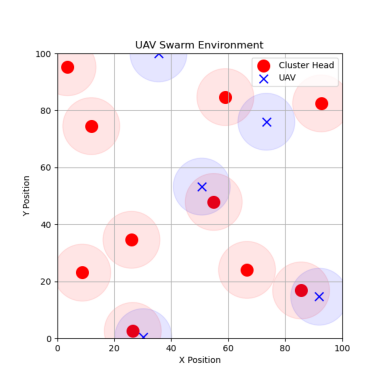

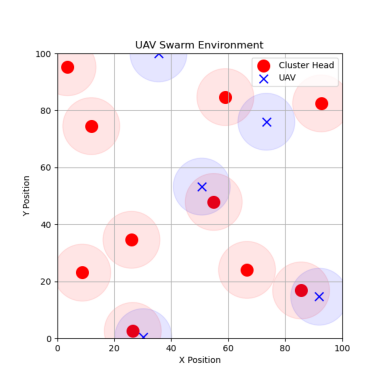

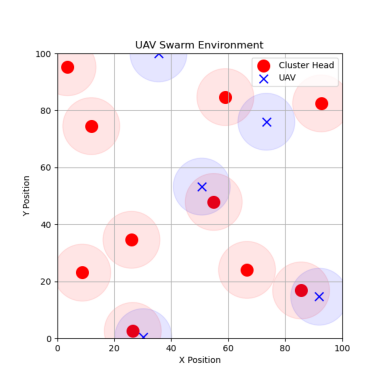

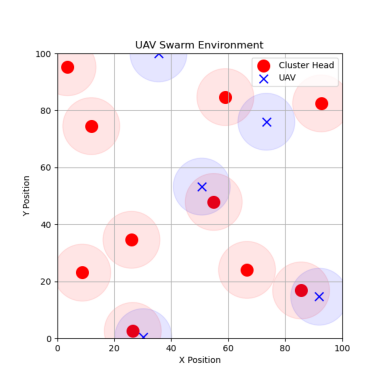

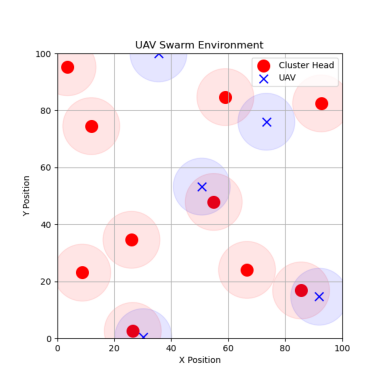

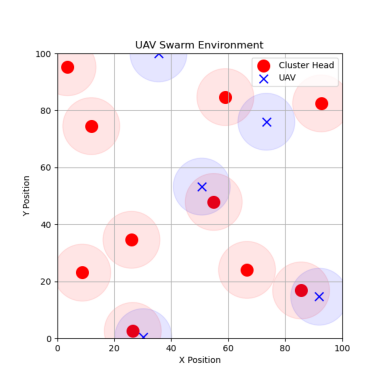

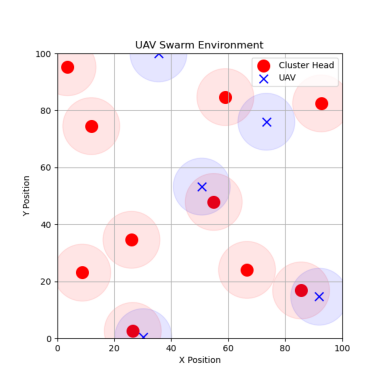

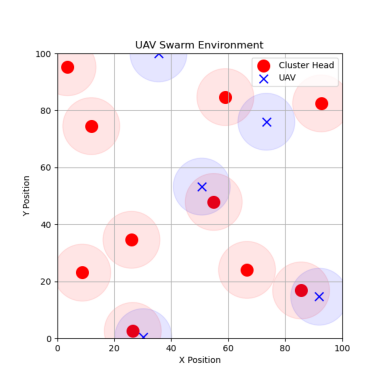

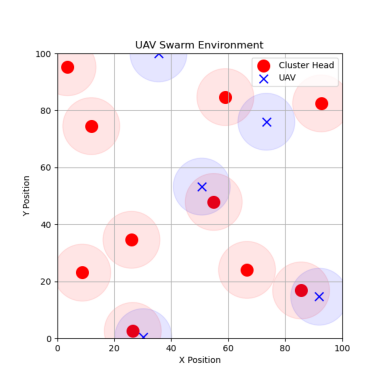

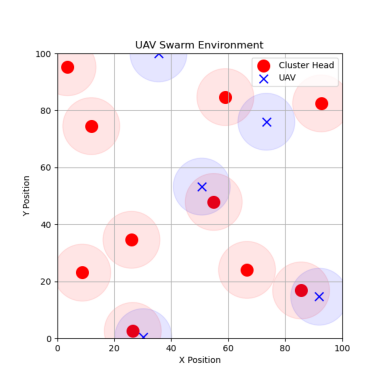

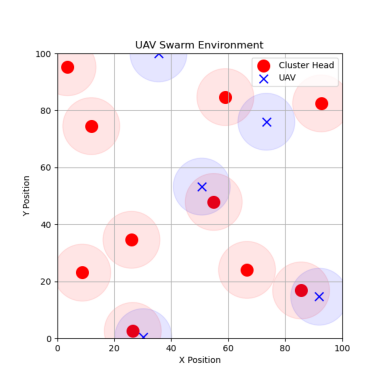

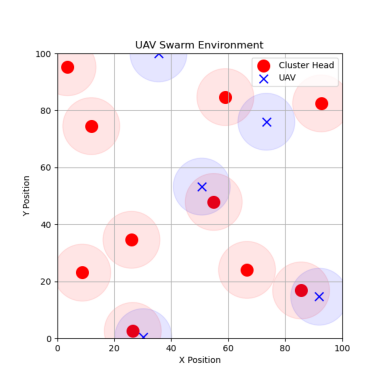

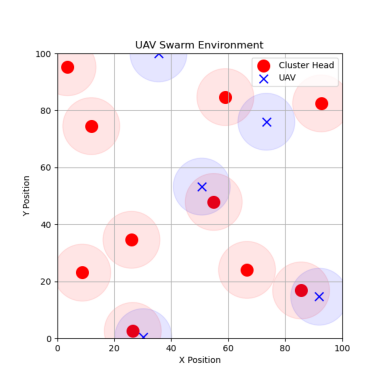

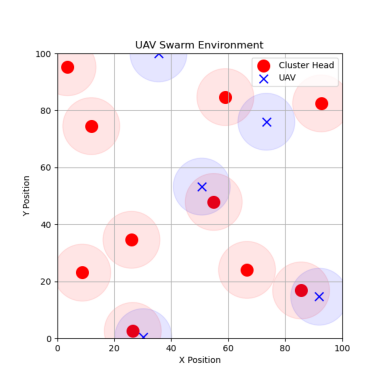

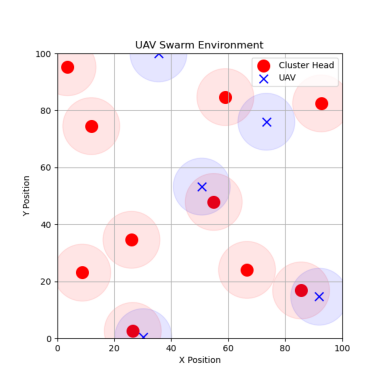

Saving video to ./gifs/uav_simulation.gif


FileNotFoundError: The directory 'C:\\Users\\aashi\\Mini-Project\\gifs' does not exist

In [36]:
model = PPO.load("./models/ppo_uav_swarm")

# Call the saveVideo function to record and save the video
saveVideo(env, model, filename="./gifs/uav_simulation.gif", num_episodes=1, fps=1, deterministic=True, frame_delay=0.1)